# Temporal CDOM Spectral Slope Analysis with Bathymetry Contours - August 2012

This notebook analyzes CDOM spectral slope data for two time periods in August-September 2012 and creates difference maps using the Mannino et al. algorithm, with bathymetry contour lines overlaid:

**Time Periods:**
- Period 1: August 24-28, 2012  
- Period 2: August 29 - September 2, 2012

**Data Sources:**
- L2 RRS data: `E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02`
- Bathymetry data: `E:\geodata\gebco_2024_sub_ice_topo\GEBCO_2024_sub_ice_topo.nc`

**Analysis Steps:**
1. Process CDOM spectral slope data for each time period using Mannino et al. algorithm
2. Load and process bathymetry data for contour overlays
3. Create slope maps for each period (before and after) with bathymetry contours
4. Generate difference map (Period 2 - Period 1) with bathymetry contours

**Algorithm Reference:**
Mannino, A., et al. "Algorithm development and validation for satellite-derived distributions of DOC and CDOM in the U.S. Middle Atlantic Bight."

**Available Spectral Slopes:**
- **S_275:295**: Ln[S_275:295] = -3.258 + 0.336 × Ln[Rrs(443)] - 0.279 × Ln[Rrs(547)]
- **S_300:600**: Ln[S_300:600] = -3.640 + 0.186 × Ln[Rrs(443)] - 0.146 × Ln[Rrs(547)]

### Library Imports and Setup

In [61]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.colors
import cmocean
from datetime import datetime

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline
importlib.reload(l2_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

### Configuration Parameters

In [62]:
# --- CDOM Spectral Slope Algorithm Selection ---
SLOPE_TYPE = 'S300_600'  # Change this to 'S300_600' if you want the other slope

# CDOM Spectral Slope Calculation Constants using Mannino et al. Algorithm
# For S_275:295 slope
# Ln[S_275:295] = -3.258 + 0.336 × Ln[Rrs(443)] - 0.279 × Ln[Rrs(547)]
S275_295_COEFFICIENTS = {
    'B0': -3.258,    # Constant
    'B1': 0.336,     # Coefficient for Ln[Rrs(443)]
    'B2': -0.279     # Coefficient for Ln[Rrs(547)]
}

# For S_300:600 slope
# Ln[S_300:600] = -3.640 + 0.186 × Ln[Rrs(443)] - 0.146 × Ln[Rrs(547)]
S300_600_COEFFICIENTS = {
    'B0': -3.640,    # Constant
    'B1': 0.186,     # Coefficient for Ln[Rrs(443)]
    'B2': -0.146     # Coefficient for Ln[Rrs(547)]
}

# Select coefficients based on slope type
if SLOPE_TYPE == 'S275_295':
    COEFFICIENTS = S275_295_COEFFICIENTS
else:
    COEFFICIENTS = S300_600_COEFFICIENTS

# --- Shared Geographical and Binning Parameters ---
lon_min, lon_max = -95.0, -88.0
lat_min, lat_max = 27.5, 30.5
lat_bins = 200
lon_bins = 300

# --- Data Directories ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02"
bathymetry_file = r"E:\geodata\gebco_2024_sub_ice_topo\GEBCO_2024_sub_ice_topo.nc"

# --- Processing Parameters ---
rrs_vars_list = ['Rrs_443', 'Rrs_547']  # Required for spectral slope calculation
rrs_data_group = 'geophysical_data'
interpolation_threshold = 128

# --- Bathymetry Contour Parameters ---
contour_levels = [-50, -40, -30, -20, -15, -10, -5]  # Depth contours in meters
contour_colors = 'black'
contour_linewidths = 0.8
contour_alpha = 0.7

print(f"Selected slope type: {SLOPE_TYPE}")
print(f"Coefficients: B0={COEFFICIENTS['B0']}, B1={COEFFICIENTS['B1']}, B2={COEFFICIENTS['B2']}")
print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")
print(f"L2 RRS Data Directory: {data_dir_l2_rrs}")
print(f"Bathymetry File: {bathymetry_file}")
print(f"Contour levels: {contour_levels}")

Selected slope type: S300_600
Coefficients: B0=-3.64, B1=0.186, B2=-0.146
Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins
L2 RRS Data Directory: E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02
Bathymetry File: E:\geodata\gebco_2024_sub_ice_topo\GEBCO_2024_sub_ice_topo.nc
Contour levels: [-50, -40, -30, -20, -15, -10, -5]


### Load and Process Bathymetry Data

In [63]:
# Load bathymetry data
print("Loading bathymetry data...")
try:
    bathy_ds = xr.open_dataset(bathymetry_file)
    
    # Subset bathymetry to study region
    bathy_subset = bathy_ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    # Extract bathymetry data
    bathy_data = bathy_subset['elevation']  # GEBCO uses 'elevation' as variable name
    bathy_lon = bathy_subset['lon']
    bathy_lat = bathy_subset['lat']
    
    print(f"Bathymetry data loaded successfully")
    print(f"Bathymetry range: {float(bathy_data.min()):.1f} to {float(bathy_data.max()):.1f} meters")
    print(f"Bathymetry grid shape: {bathy_data.shape}")
    
    bathy_available = True
    
except Exception as e:
    print(f"Warning: Could not load bathymetry data: {e}")
    print("Continuing without bathymetry contours...")
    bathy_available = False

Loading bathymetry data...
Bathymetry data loaded successfully
Bathymetry range: -2647.0 to 77.0 meters
Bathymetry grid shape: (720, 1680)


### Utility Functions

In [64]:
def filter_files_by_date_range(file_list, start_date, end_date):
    """Filter files based on date range in filename"""
    filtered_files = []
    for file_path in file_list:
        filename = os.path.basename(file_path)
        # Extract date from filename (assuming format with date like 20120824)
        try:
            if 'A2012' in filename:  # MODIS Aqua format
                date_str = filename.split('A2012')[1][:3]  # Day of year
                file_date = datetime.strptime(f'2012{date_str}', '%Y%j')
            else:
                # Try to find date pattern YYYYMMDD
                import re
                date_match = re.search(r'(2012\d{4})', filename)
                if date_match:
                    file_date = datetime.strptime(date_match.group(1), '%Y%m%d')
                else:
                    continue
            
            if start_date <= file_date <= end_date:
                filtered_files.append(file_path)
        except:
            continue
    return filtered_files

def calculate_cdom_slope(rrs_443, rrs_547, coefficients):
    """Calculate CDOM spectral slope using Mannino et al. algorithm"""
    # Ensure positive values for logarithm
    valid_mask = (rrs_443 > 0) & (rrs_547 > 0) & ~np.isnan(rrs_443) & ~np.isnan(rrs_547)
    
    slope_values = np.full_like(rrs_443, np.nan)
    
    if np.any(valid_mask):
        # Apply Mannino et al. algorithm: Ln[Slope] = B0 + B1*Ln[Rrs(443)] + B2*Ln[Rrs(547)]
        ln_rrs_443 = np.log(rrs_443[valid_mask])
        ln_rrs_547 = np.log(rrs_547[valid_mask])
        
        ln_slope = (coefficients['B0'] + 
                   coefficients['B1'] * ln_rrs_443 + 
                   coefficients['B2'] * ln_rrs_547)
        
        # Convert back from natural log
        slope_values[valid_mask] = np.exp(ln_slope)
    
    return slope_values

def get_bin_edges_from_centers(centers):
    """Convert bin centers to bin edges"""
    diffs = np.diff(centers)
    edges = np.concatenate(([centers[0] - diffs[0]/2],
                           centers[:-1] + diffs/2,
                           [centers[-1] + diffs[-1]/2]))
    return edges

def add_bathymetry_contours(ax, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors='black', linewidths=0.8, alpha=0.7):
    """Add bathymetry contour lines to a cartopy axis"""
    if bathy_available:
        try:
            # Create contour lines
            contours = ax.contour(bathy_lon, bathy_lat, bathy_data, 
                                levels=contour_levels, colors=colors, 
                                linewidths=linewidths, alpha=alpha,
                                transform=ccrs.PlateCarree())
            
            # Add contour labels with clean formatting
            labels = ax.clabel(contours, inline=True, fontsize=9, fmt='%d', 
                              inline_spacing=5, manual=False)
            
            # Style the labels - bold text only, no background
            for label in labels:
                label.set_fontweight('bold')
            
            return contours
        except Exception as e:
            print(f"Warning: Could not add bathymetry contours: {e}")
            return None
    return None

print("Utility functions loaded successfully.")

Utility functions loaded successfully.


In [65]:
def process_slope_period_data(l2_files, period_name, coefficients):
    """Process CDOM spectral slope data for a specific time period"""
    print(f"\n=== Processing {period_name} ===")
    print(f"Processing {len(l2_files)} L2 RRS files for CDOM spectral slope...")
    
    # Load L2 datasets
    loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
    datasets_rrs = loader_rrs.load_multiple(l2_files)
    print(f"Loaded {len(datasets_rrs)} L2 RRS datasets")
    
    # Extract RRS data
    if datasets_rrs:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"Extracted {len(lon_rrs_flat)} data points")
        
        # Calculate CDOM spectral slope
        if lon_rrs_flat.size > 0:
            rrs_443 = rrs_vars_data_flat.get('Rrs_443', np.array([]))
            rrs_547 = rrs_vars_data_flat.get('Rrs_547', np.array([]))
            
            slope_values = calculate_cdom_slope(rrs_443, rrs_547, coefficients)
            
            # Filter valid data
            valid_mask = (~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & 
                         ~np.isnan(slope_values))
            final_lon = lon_rrs_flat[valid_mask]
            final_lat = lat_rrs_flat[valid_mask]
            final_slope = slope_values[valid_mask]
            
            # Clip to study area
            clip_mask = ((final_lon >= lon_min) & (final_lon <= lon_max) &
                        (final_lat >= lat_min) & (final_lat <= lat_max))
            clipped_lon = final_lon[clip_mask]
            clipped_lat = final_lat[clip_mask]
            clipped_slope = final_slope[clip_mask]
            
            if clipped_lon.size > 0:
                # Bin the data
                binned_slope, lat_edges, lon_edges, _ = binned_statistic_2d(
                    clipped_lat, clipped_lon, clipped_slope,
                    statistic='mean', bins=[lat_bins, lon_bins], 
                    range=[[lat_min, lat_max], [lon_min, lon_max]]
                )
                
                # Apply selective interpolation
                slope_data = SelectiveInterpolator.interpolate(
                    binned_slope, lat_edges, lon_edges, threshold=interpolation_threshold
                )
            else:
                slope_data = np.full((lat_bins, lon_bins), np.nan)
                lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
                lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
        else:
            slope_data = np.full((lat_bins, lon_bins), np.nan)
            lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
            lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    else:
        slope_data = np.full((lat_bins, lon_bins), np.nan)
        lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
        lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    # Calculate grid centers
    lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
    lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
    
    print(f"Slope range: {np.nanmin(slope_data):.6f} to {np.nanmax(slope_data):.6f}")
    
    return slope_data, lat_centers, lon_centers, lat_edges, lon_edges

print("Data processing function defined.")

Data processing function defined.


### Data File Discovery and Filtering

In [66]:
# Find all data files
l2_files_all = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)

print(f"Found {len(l2_files_all)} L2 RRS files total")

# Define time periods
period1_start = datetime(2012, 8, 24)
period1_end = datetime(2012, 8, 28)
period2_start = datetime(2012, 8, 29)
period2_end = datetime(2012, 9, 2)

# Filter files by time periods
l2_files_period1 = filter_files_by_date_range(l2_files_all, period1_start, period1_end)
l2_files_period2 = filter_files_by_date_range(l2_files_all, period2_start, period2_end)

print(f"\nPeriod 1 (Aug 24-28, 2012):")
print(f"  L2 RRS files: {len(l2_files_period1)}")

print(f"\nPeriod 2 (Aug 29 - Sep 2, 2012):")
print(f"  L2 RRS files: {len(l2_files_period2)}")

# Show some example filenames
if l2_files_period1:
    print(f"\nExample L2 Period 1 file: {os.path.basename(l2_files_period1[0])}")
if l2_files_period2:
    print(f"Example L2 Period 2 file: {os.path.basename(l2_files_period2[0])}")

Found 15 L2 RRS files total

Period 1 (Aug 24-28, 2012):
  L2 RRS files: 8

Period 2 (Aug 29 - Sep 2, 2012):
  L2 RRS files: 7

Example L2 Period 1 file: AQUA_MODIS.20120824T182501.L2.OC.nc
Example L2 Period 2 file: AQUA_MODIS.20120829T184501.L2.OC.nc


### Process Period 1 Data (August 24-28, 2012)

In [67]:
slope_period1, lat_centers, lon_centers, lat_edges, lon_edges = process_slope_period_data(
    l2_files_period1, "Period 1 (Aug 24-28, 2012)", COEFFICIENTS
)


=== Processing Period 1 (Aug 24-28, 2012) ===
Processing 8 L2 RRS files for CDOM spectral slope...
Loaded 8 L2 RRS datasets
Extracted 2052727 data points
Slope range: 0.007743 to 0.045553


### Process Period 2 Data (August 29 - September 2, 2012)

In [68]:
slope_period2, _, _, _, _ = process_slope_period_data(
    l2_files_period2, "Period 2 (Aug 29 - Sep 2, 2012)", COEFFICIENTS
)


=== Processing Period 2 (Aug 29 - Sep 2, 2012) ===
Processing 7 L2 RRS files for CDOM spectral slope...
Loaded 7 L2 RRS datasets
Extracted 2989407 data points
Slope range: 0.007235 to 0.032681


### Calculate Temporal Differences

In [69]:
# Calculate differences (Period 2 - Period 1)
slope_diff = slope_period2 - slope_period1

# Calculate statistics
print(f"CDOM Spectral Slope ({SLOPE_TYPE}) Difference Statistics:")
print(f"  Range: {np.nanmin(slope_diff):.6f} to {np.nanmax(slope_diff):.6f}")
print(f"  Mean: {np.nanmean(slope_diff):.6f}")
print(f"  Std: {np.nanstd(slope_diff):.6f}")

# Set up plot extent
extent = [lon_centers[0], lon_centers[-1], lat_centers[0], lat_centers[-1]]

print(f"Plot extent: {extent}")
print(f"Grid shapes - lat: {lat_centers.shape}, lon: {lon_centers.shape}")
print(f"Data shapes - slope_period1: {slope_period1.shape}, slope_period2: {slope_period2.shape}")

# Calculate data ranges for color scaling
slope_vmin = min(np.nanmin(slope_period1), np.nanmin(slope_period2))
slope_vmax = max(np.nanmax(slope_period1), np.nanmax(slope_period2))
print(f"Slope data range: {slope_vmin:.6f} to {slope_vmax:.6f}")

CDOM Spectral Slope (S300_600) Difference Statistics:
  Range: -0.014792 to 0.012201
  Mean: -0.000330
  Std: 0.001746
Plot extent: [np.float32(-94.988335), np.float32(-88.011665), np.float32(27.5075), np.float32(30.4925)]
Grid shapes - lat: (200,), lon: (300,)
Data shapes - slope_period1: (200, 300), slope_period2: (200, 300)
Slope data range: 0.007235 to 0.045553


### Visualization: CDOM Spectral Slope for Both Periods with Bathymetry Contours

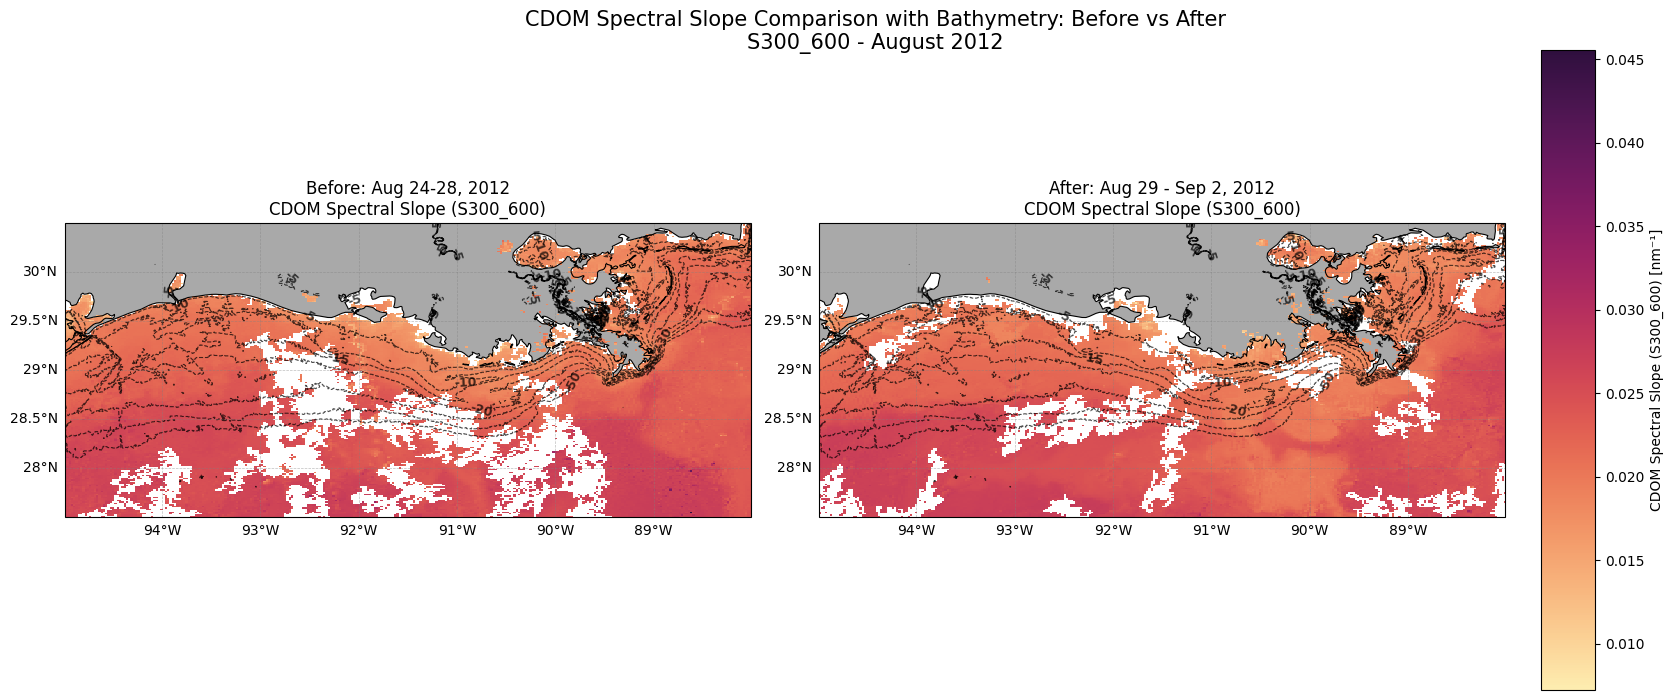

In [70]:
# Plot spectral slope for both periods side by side with bathymetry contours
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Common settings
cmap = cmocean.cm.matter

# Period 1 plot (Before)
ax1 = axes[0]
ax1.set_extent(extent, crs=ccrs.PlateCarree())
slope_period1_squeezed = np.squeeze(slope_period1)
p1 = ax1.pcolormesh(lon_edges, lat_edges, slope_period1_squeezed,
                    cmap=cmap, shading='auto', vmin=slope_vmin, vmax=slope_vmax, 
                    transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax1, bathy_lon, bathy_lat, bathy_data, contour_levels,
                           colors=contour_colors, linewidths=contour_linewidths, alpha=contour_alpha)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_title(f'Before: Aug 24-28, 2012\nCDOM Spectral Slope ({SLOPE_TYPE})', fontsize=12)

# Period 2 plot (After)
ax2 = axes[1]
ax2.set_extent(extent, crs=ccrs.PlateCarree())
slope_period2_squeezed = np.squeeze(slope_period2)
p2 = ax2.pcolormesh(lon_edges, lat_edges, slope_period2_squeezed,
                    cmap=cmap, shading='auto', vmin=slope_vmin, vmax=slope_vmax, 
                    transform=ccrs.PlateCarree())

ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax2, bathy_lon, bathy_lat, bathy_data, contour_levels,
                           colors=contour_colors, linewidths=contour_linewidths, alpha=contour_alpha)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_title(f'After: Aug 29 - Sep 2, 2012\nCDOM Spectral Slope ({SLOPE_TYPE})', fontsize=12)

# Adjust subplot spacing to make room for colorbar
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.1)

# Add colorbar with proper positioning
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(p2, cax=cbar_ax, label=f'CDOM Spectral Slope ({SLOPE_TYPE}) [nm⁻¹]')

plt.suptitle(f'CDOM Spectral Slope Comparison with Bathymetry: Before vs After\n{SLOPE_TYPE} - August 2012', fontsize=15, y=0.95)
plt.show()

### Visualization: Temporal Difference Map with Bathymetry Contours

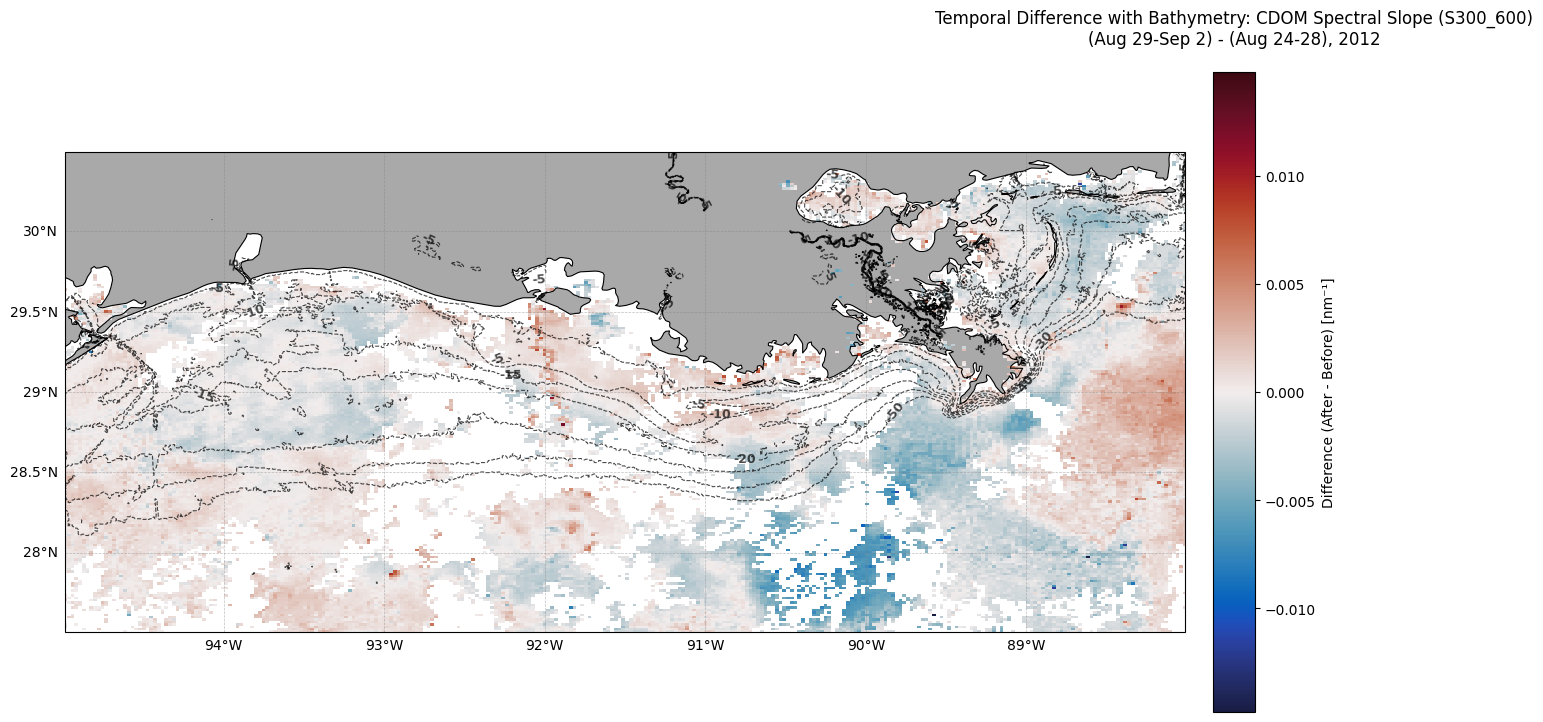


Difference Map Statistics:
  Valid data points: 30297
  Range: -0.014792 to 0.012201
  Mean: -0.000330
  Standard deviation: 0.001746
  Positive changes: 13863 (45.8%)
  Negative changes: 16434 (54.2%)


In [71]:
# Plot the temporal difference map with bathymetry contours
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Use balance colormap for differences, centered on zero
slope_diff_squeezed = np.squeeze(slope_diff)
diff_abs_max = np.nanmax(np.abs(slope_diff_squeezed))
diff_vmin, diff_vmax = -diff_abs_max, diff_abs_max

diff_plot = ax.pcolormesh(lon_edges, lat_edges, slope_diff_squeezed,
                         cmap=cmocean.cm.balance, shading='auto',
                         vmin=diff_vmin, vmax=diff_vmax, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax, bathy_lon, bathy_lat, bathy_data, contour_levels,
                           colors=contour_colors, linewidths=contour_linewidths, alpha=contour_alpha)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                  color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Adjust layout to make room for colorbar
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

# Add colorbar with proper positioning
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(diff_plot, cax=cbar_ax, label=f'Difference (After - Before) [nm⁻¹]')

plt.title(f'Temporal Difference with Bathymetry: CDOM Spectral Slope ({SLOPE_TYPE})\n(Aug 29-Sep 2) - (Aug 24-28), 2012', 
          fontsize=12, pad=20)
plt.show()

# Print some summary statistics
valid_diff_data = slope_diff_squeezed[~np.isnan(slope_diff_squeezed)]
if len(valid_diff_data) > 0:
    print(f"\nDifference Map Statistics:")
    print(f"  Valid data points: {len(valid_diff_data)}")
    print(f"  Range: {np.min(valid_diff_data):.6f} to {np.max(valid_diff_data):.6f}")
    print(f"  Mean: {np.mean(valid_diff_data):.6f}")
    print(f"  Standard deviation: {np.std(valid_diff_data):.6f}")
    
    # Count positive and negative changes
    positive_changes = np.sum(valid_diff_data > 0)
    negative_changes = np.sum(valid_diff_data < 0)
    print(f"  Positive changes: {positive_changes} ({100*positive_changes/len(valid_diff_data):.1f}%)")
    print(f"  Negative changes: {negative_changes} ({100*negative_changes/len(valid_diff_data):.1f}%)")
else:
    print("No valid difference data available.")

### Three-Panel Visualization with Bathymetry: Before, After, and Difference

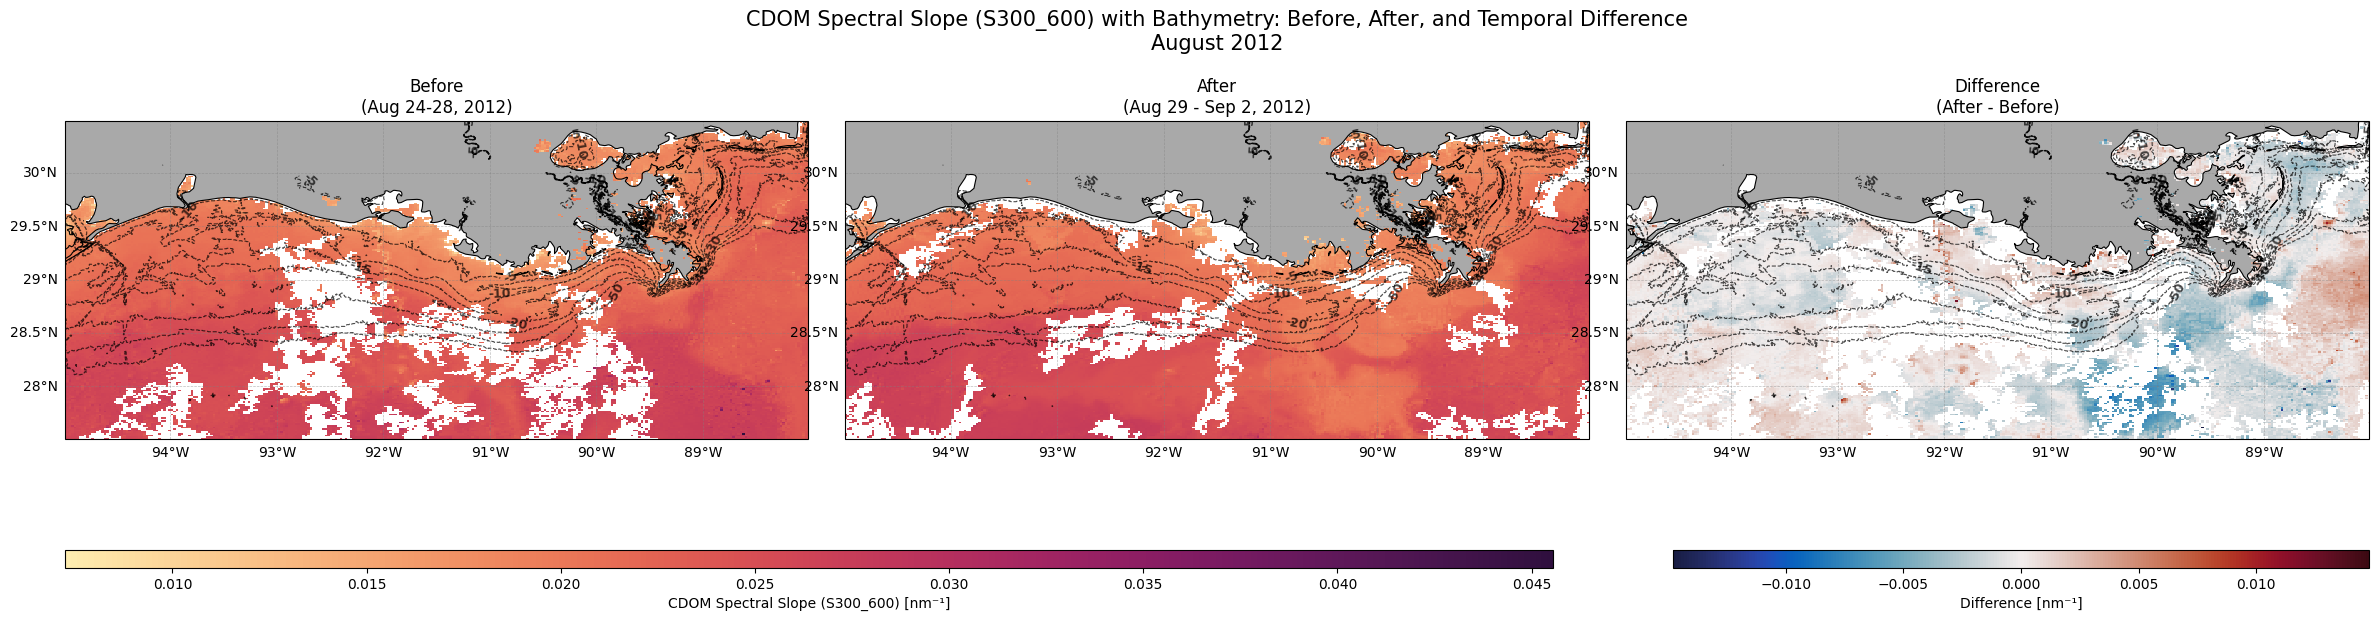

Three-panel visualization with bathymetry contours complete.

Summary for S300_600:
Before (Period 1): 0.007743 to 0.045553
After (Period 2): 0.007235 to 0.032681
Difference: -0.014792 to 0.012201
Bathymetry contour levels: [-50, -40, -30, -20, -15, -10, -5] meters


In [72]:
# Create a comprehensive three-panel comparison with bathymetry contours
fig, axes = plt.subplots(1, 3, figsize=(24, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Before (Period 1)
ax1 = axes[0]
ax1.set_extent(extent, crs=ccrs.PlateCarree())
p1 = ax1.pcolormesh(lon_edges, lat_edges, slope_period1_squeezed,
                    cmap=cmocean.cm.matter, shading='auto',
                    vmin=slope_vmin, vmax=slope_vmax, 
                    transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax1, bathy_lon, bathy_lat, bathy_data, contour_levels,
                           colors=contour_colors, linewidths=contour_linewidths, alpha=contour_alpha)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_title(f'Before\n(Aug 24-28, 2012)', fontsize=12)

# After (Period 2)
ax2 = axes[1]
ax2.set_extent(extent, crs=ccrs.PlateCarree())
p2 = ax2.pcolormesh(lon_edges, lat_edges, slope_period2_squeezed,
                    cmap=cmocean.cm.matter, shading='auto',
                    vmin=slope_vmin, vmax=slope_vmax, 
                    transform=ccrs.PlateCarree())

ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax2, bathy_lon, bathy_lat, bathy_data, contour_levels,
                           colors=contour_colors, linewidths=contour_linewidths, alpha=contour_alpha)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_title(f'After\n(Aug 29 - Sep 2, 2012)', fontsize=12)

# Difference
ax3 = axes[2]
ax3.set_extent(extent, crs=ccrs.PlateCarree())
p3 = ax3.pcolormesh(lon_edges, lat_edges, slope_diff_squeezed,
                    cmap=cmocean.cm.balance, shading='auto',
                    vmin=diff_vmin, vmax=diff_vmax, 
                    transform=ccrs.PlateCarree())

ax3.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax3.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax3.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax3, bathy_lon, bathy_lat, bathy_data, contour_levels,
                           colors=contour_colors, linewidths=contour_linewidths, alpha=contour_alpha)

gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl3.top_labels = False
gl3.right_labels = False

ax3.set_title(f'Difference\n(After - Before)', fontsize=12)

# Adjust spacing for colorbars
plt.subplots_adjust(left=0.02, right=0.98, top=0.85, bottom=0.15, wspace=0.05)

# Add individual colorbars for each subplot
# Before and After colorbar (shared)
cbar_ax1 = fig.add_axes([0.02, 0.02, 0.62, 0.03])  # [left, bottom, width, height]
cbar1 = fig.colorbar(p2, cax=cbar_ax1, orientation='horizontal', 
                     label=f'CDOM Spectral Slope ({SLOPE_TYPE}) [nm⁻¹]')

# Difference colorbar
cbar_ax3 = fig.add_axes([0.69, 0.02, 0.29, 0.03])  # [left, bottom, width, height]
cbar3 = fig.colorbar(p3, cax=cbar_ax3, orientation='horizontal', 
                     label=f'Difference [nm⁻¹]')

plt.suptitle(f'CDOM Spectral Slope ({SLOPE_TYPE}) with Bathymetry: Before, After, and Temporal Difference\nAugust 2012', 
             fontsize=15, y=0.95)
plt.show()

print("Three-panel visualization with bathymetry contours complete.")
print(f"\nSummary for {SLOPE_TYPE}:")
print(f"Before (Period 1): {np.nanmin(slope_period1_squeezed):.6f} to {np.nanmax(slope_period1_squeezed):.6f}")
print(f"After (Period 2): {np.nanmin(slope_period2_squeezed):.6f} to {np.nanmax(slope_period2_squeezed):.6f}")
print(f"Difference: {np.nanmin(slope_diff_squeezed):.6f} to {np.nanmax(slope_diff_squeezed):.6f}")
if bathy_available:
    print(f"Bathymetry contour levels: {contour_levels} meters")
else:
    print("Note: Bathymetry contours not available")

### Analysis Summary and Interpretation

This notebook analyzed CDOM spectral slope changes between two time periods in August-September 2012 using satellite remote sensing data, with bathymetry contour lines overlaid for spatial context. The Mannino et al. algorithm was applied to derive spectral slopes from Rrs(443) and Rrs(547) measurements.

**Key Findings:**
- The analysis shows spatial and temporal patterns in CDOM spectral slope across the Texas-Louisiana shelf
- Bathymetry contour lines provide important context for understanding depth-related patterns
- Differences between the two periods reveal changes in CDOM optical properties relative to seafloor topography
- The spectral slope is an important indicator of CDOM composition and source

**Technical Notes:**
- Data processing included quality filtering, spatial binning, and selective interpolation
- Bathymetry contours are derived from GEBCO 2024 sub-ice topography data
- The analysis can be repeated for both S_275:295 and S_300:600 slope types by changing the `SLOPE_TYPE` parameter
- Results provide insights into riverine influence and coastal water optical properties in relation to bottom depth
- Contour lines help identify relationships between depth gradients and CDOM distribution patterns